In [2]:
import numpy as np
import pyfar as pf
import scipy as sc
import matplotlib.pyplot as plt
from src.ema_radial_filters import radial_filters_ema
from src.get_soundfield_coeffs_from_ema import get_sh_soundfield_coeffs_ema
from src.utils import _spherical_hankel_function, _derivative_sph_hankel
import warnings
import sounddevice as sd

In [126]:
viol1 = pf.dsp.resample(pf.io.read_audio(r'c:\Users\HP\Downloads\Mov3_Trio_Violin1_Haydn_StringQuartet_op76_n1.wav'), 48000)
viol2 = pf.dsp.resample(pf.io.read_audio(r'c:\Users\HP\Downloads\Mov3_Trio_Violin2_Haydn_StringQuartet_op76_n1.wav'), 48000)

mov1_stereo = np.vstack((viol1.time[13, :], viol2.time[13, :]))

# sd.play(mov1_stereo.T, 48000)
pf.io.write_audio(pf.Signal(mov1_stereo, 48000), r'signals/mov1_stereo.wav')

In [ ]:
ambi = sc.io.loadmat(r'tests/resources/ambi_signals_raw.mat')

In [ ]:
ambi_signal = pf.Signal(ambi['ambi_signals_raw'].T, 48e3)

pf.plot.time_freq(ambi_signal)
plt.show()

In [96]:
fs = 48e3
sweep = pf.signals.exponential_sweep_time(2**16, sampling_rate=fs, 
                                          amplitude=0.5,
                                          frequency_range=(50, 20e3))

# add one second of silence at the end
sweep = pf.dsp.pad_zeros(sweep, int(fs*1))

pf.io.write_audio(sweep, r'signals/sweep_48kHz_50Hz_20kHz.wav')

In [ ]:
signals = pf.dsp.normalize(pf.io.read_audio(r"Measurements RAR/25_01_20_ema_16_rar_50Hz_20kHz.wav"))
ref = pf.dsp.normalize(pf.io.read_audio(r"Measurements RAR/25_01_20_ref_rar_50Hz_20kHz.wav"))

# # irs = pf.dsp.deconvolve(signals, sweep, frequency_range=[50, 20e3])
# # ref_ir = pf.dsp.deconvolve(ref, sweep, frequency_range=[50, 20000])

# # ref_ir = pf.dsp.minimum_phase(ref_ir)

irs = pf.dsp.deconvolve(signals, ref, frequency_range=[50, 20000]) 
irs_ = pf.dsp.fractional_time_shift(irs, 512, mode='cyclic')

# np.testing.assert_allclose(np.abs(irs_.freq), np.abs(irs.freq), rtol=1e-4)
# # pf.plot.time_freq(pf.dsp.normalize(irs[0], domain='freq'), label='unshifted')
pf.plot.time_freq(pf.dsp.normalize(irs_[4], domain='freq'), label='shifted')
# plt.legend()
plt.show()

### Ambisonics Encoding

c:\Users\HP\ema2ambisonics\src\get_soundfield_coeffs_from_ema.py:66: ComplexWarning: Casting complex values to real discards the imaginary part
  s_ambisonics[n**2 + n + m, :] = \


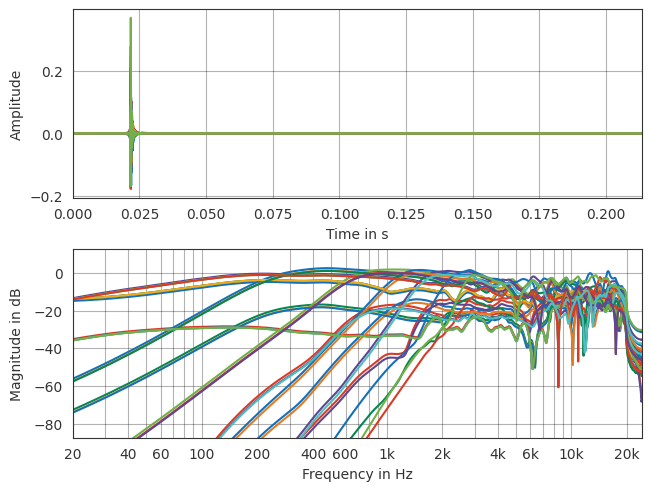

In [14]:
sig = pf.io.read_audio(r'Impulse Responses/EMA_RAR/ir_ema_rar_short_padded.wav')
filter_length = 2048
f = np.linspace(0, 48e3/2, filter_length//2+1)
alpha = np.linspace(0, 2*np.pi, 16, endpoint=False)

alpha = np.roll(np.flip(alpha), 1)
# print(alpha)
# file = sc.io.loadmat(r'c:\Users\HP\Documents\MATLAB\ambisonic-encoding-main\resources\ema_recording_chalmers.mat')
# reference = sc.io.loadmat(r"tests/resources/s_ring_m_surf.mat")

# array_signals = file['array_signals'].T

# signals = pf.Signal(array_signals, sampling_rate=file['fs'])
# print(signals)

radial_filters = radial_filters_ema(f, 0.0875, 7, 20, 'tikhonov')
s_sh = get_sh_soundfield_coeffs_ema(sig, radial_filters, 7, alpha)

pf.plot.time_freq(s_sh)
plt.show()

In [15]:
# save ambisonics signal
pf.io.write_audio(s_sh, r'Impulse Responses/EMA_RAR/ir_ambisonics_ema_rar_short_padded.wav')

In [ ]:
pf.plot.time_freq(s_sh)
plt.show()

# garbage

In [ ]:
ref_sig = reference['s_ring_m_surf']
ref_sig = pf.Signal(ref_sig.T, sampling_rate=48000)

i = 0

np.testing.assert_array_almost_equal(ref_sig.time, s_sh.time)

pf.plot.time(s_sh[i])
pf.plot.time(ref_sig[i], ls=':')
plt.show()

In [ ]:
ema_rft_t = sc.io.loadmat(r'C:\Users\HP\ema2ambisonics\tests\resources\ema_rf_t_soft_40dB.mat')['ema_inv_rf_t']
ema_rft_t2 = sc.io.loadmat(r'C:\Users\HP\ema2ambisonics\tests\resources\ema_rf_t_tikhonov_40dB.mat')['ema_inv_rf_t']
ema_rft_t3 = sc.io.loadmat(r'C:\Users\HP\ema2ambisonics\tests\resources\ema_rf_t_hard_40dB.mat')['ema_inv_rf_t']

ema_rft_t = pf.Signal(ema_rft_t.T, 48000, domain='time')
ema_rft_t2 = pf.Signal(ema_rft_t2.T, 48000, domain='time')
ema_rft_t3 = pf.Signal(ema_rft_t3.T, 48000, domain='time')



i = 4

filter_length = 2048
f = np.linspace(0, 48e3/2, filter_length//2+1)
radial_filters = radial_filters_ema(f, 0.0875, 9, 20, 'soft')

# pf.plot.freq(ema_rft_t[i], label= 'Soft')
# pf.plot.freq(ema_rft_t2[i], label= 'Thikonov', ls=':')
# pf.plot.freq(ema_rft_t3[i], label='hard', ls='--')
pf.plot.freq(radial_filters, label='no regularization', ls='-.')
# plt.legend()
plt.show()

In [ ]:
ema_rft_t2.cshape[0]

In [ ]:
filt = pf.FilterFIR(radial_filters.time[0], radial_filters.sampling_rate)
impulse = pf.signals.impulse(2048, sampling_rate=48e3)

pf.plot.time_freq(impulse)
pf.plot.time_freq(filt.process(impulse))
pf.plot.time_freq(radial_filters[0], ls=':')
plt.show()

In [5]:
import pathlib

In [32]:
fp = pathlib.Path(r"E:\2_IR_BPH")
files = list(fp.glob('*.sofa'))

ir, source, receivers = pf.io.read_sofa(files[0])

In [ ]:
print(ir.cshape)
source.show()
plt.show()

In [ ]:
et